In [1]:
!pip install opencv-python tensorflow

In [2]:

import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array


In [4]:
normal_dir = r'C:\Users\Naman\Desktop\research work\models\lungs\chest_xray\chest_xray\train\NORMAL'
normal_img = [f for f in os.listdir(normal_dir) if os.path.isfile(os.path.join(normal_dir, f))]
normal_img[:10]

['IM-0115-0001.jpeg',
 'IM-0117-0001.jpeg',
 'IM-0119-0001.jpeg',
 'IM-0122-0001.jpeg',
 'IM-0125-0001.jpeg',
 'IM-0127-0001.jpeg',
 'IM-0128-0001.jpeg',
 'IM-0129-0001.jpeg',
 'IM-0131-0001.jpeg',
 'IM-0133-0001.jpeg']

In [5]:
print(len(normal_img))

1341


In [6]:
pneumonia_dir = r'C:\Users\Naman\Desktop\research work\models\lungs\chest_xray\chest_xray\train\PNEUMONIA'
pneumonia_img = [f for f in os.listdir(pneumonia_dir) if os.path.isfile(os.path.join(pneumonia_dir, f))]
pneumonia_img = pneumonia_img[:1300]
pneumonia_img[:10]

['person1000_bacteria_2931.jpeg',
 'person1000_virus_1681.jpeg',
 'person1001_bacteria_2932.jpeg',
 'person1002_bacteria_2933.jpeg',
 'person1003_bacteria_2934.jpeg',
 'person1003_virus_1685.jpeg',
 'person1004_bacteria_2935.jpeg',
 'person1004_virus_1686.jpeg',
 'person1005_bacteria_2936.jpeg',
 'person1005_virus_1688.jpeg']

In [7]:
print(len(pneumonia_img))

1300


In [8]:
import os
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir1 = r'C:\Users\Naman\Desktop\research work\models\lungs\chest_xray\chest_xray\train\PNEUMONIA'
dataset_dir2 = r'C:\Users\Naman\Desktop\research work\models\lungs\chest_xray\chest_xray\train\NORMAL'
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        if label == 1:
            image_path = os.path.join(dataset_dir1, img)
        else:
            image_path = os.path.join(dataset_dir2, img)

        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [9]:
dataset = create_dataset(pneumonia_img,1)

100%|██████████| 1300/1300 [00:21<00:00, 60.06it/s]


In [10]:
len(dataset)

1300

In [11]:
dataset = create_dataset(normal_img,0)

100%|██████████| 1341/1341 [00:50<00:00, 26.44it/s]


In [28]:
len(dataset)

2641

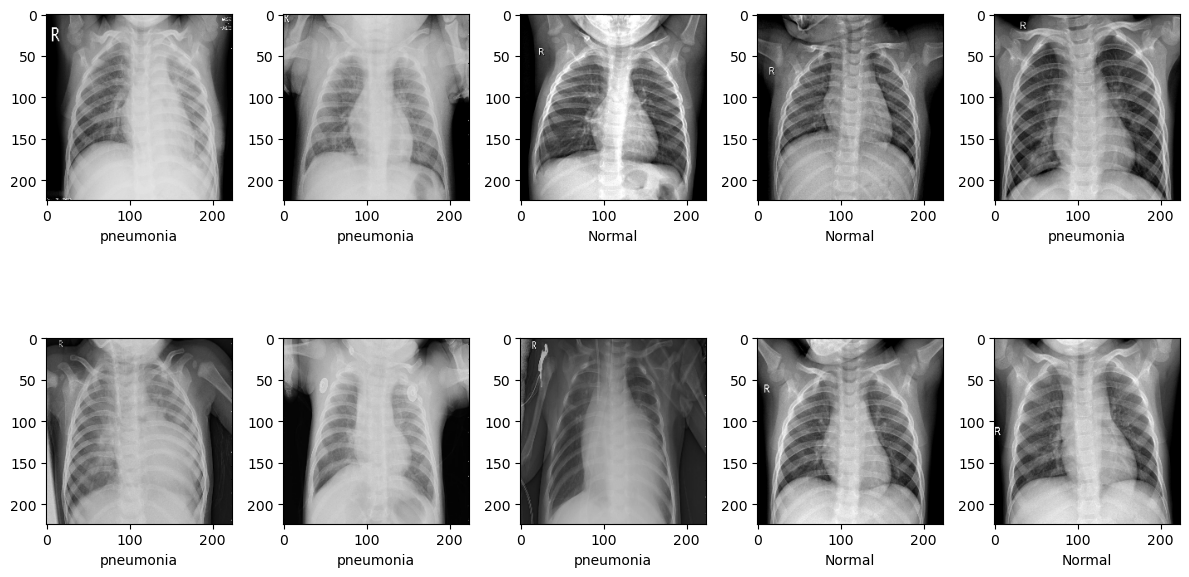

In [29]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "pneumonia"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()  

In [30]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [31]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [32]:
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))


In [33]:
for layer in resnet.layers:
    layer.trainable = False

In [34]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense, Dropout
model = Sequential()
model.add(resnet)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

In [35]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [36]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("resnet.keras", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, save_freq='epoch')
earlystop = EarlyStopping(monitor="val_accuracy", patience=10, verbose=1)

In [45]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=len(x_train) // 32,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint, earlystop]
)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9343 - loss: 0.2278
Epoch 1: val_accuracy improved from -inf to 0.94518, saving model to resnet.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9343 - loss: 0.2275 - val_accuracy: 0.9452 - val_loss: 0.1246
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.94518
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 343ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9452 - val_loss: 0.1246
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9349 - loss: 0.1749
Epoch 3: val_accuracy did not improve from 0.94518
66/66 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9349 - loss: 0.1751 - val_accuracy: 0.9414 - val_loss: 0.1405
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.94518
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 352ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9414 - val_loss: 0.1405
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9317 - loss: 0.1828
Epoch 5:

In [39]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

17/17 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9408 - loss: 0.1665
loss: 0.14998114109039307
Accuracy: 0.9413988590240479


In [40]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test,y_pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       279
           1       0.99      0.88      0.93       250

    accuracy                           0.94       529
   macro avg       0.95      0.94      0.94       529
weighted avg       0.95      0.94      0.94       529



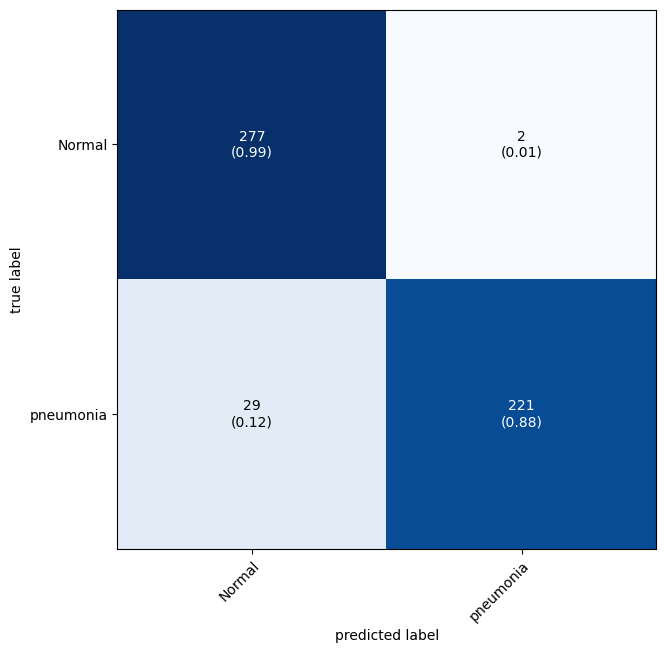

In [42]:
!pip install mlxtend
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","pneumonia"],
                      show_normed = True);

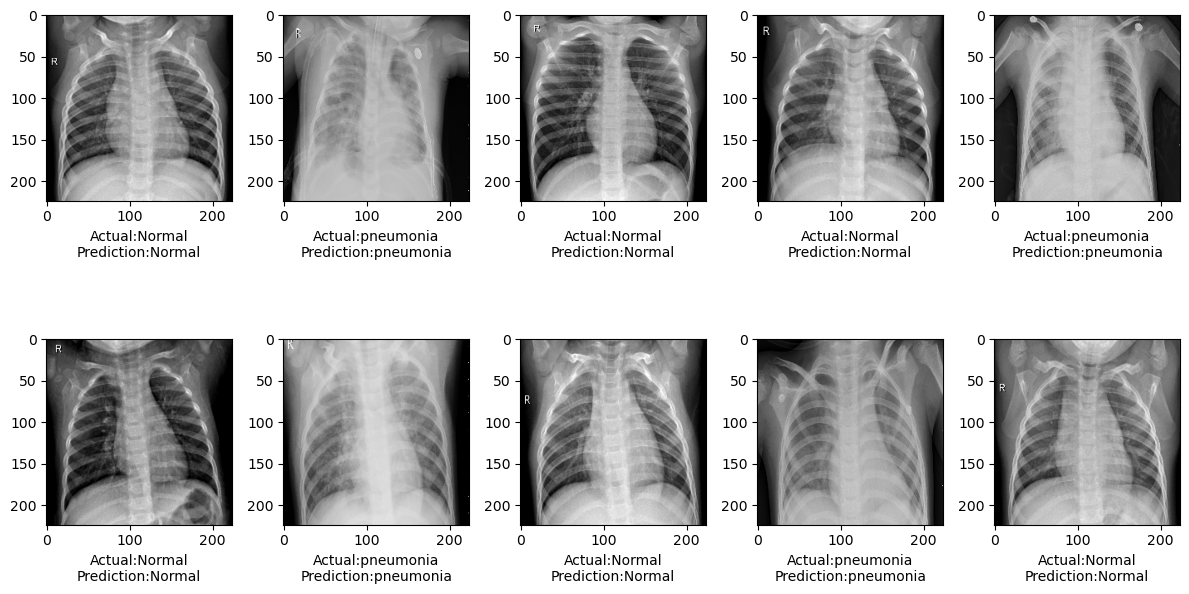

In [41]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "pneumonia"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "pneumonia"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 